In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from geo_tool import Point_Cloud

import tf_lab.autopredictors.scripts.minhyuk_data as minhyuk_data
from tf_lab.autopredictors.scripts.minhyuk_data import KinectData
from tf_lab.autopredictors.evaluate import accuracy_of_completion, coverage_of_completion

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import unpickle_data
from general_tools.in_out.basics import create_dir

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
incomplete_n_samples = 2048
complete_n_samples = 4096
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

predictor_loss = 'chamfer'

# predictor_type = 'chair', or 'table', or all_classes_in_dai'   # indicated training data used for making Predictor.
predictor_type = 'all_classes_in_dai' 

In [11]:
predictor_name = predictor_type + '_2048_4096pts_' + predictor_loss + '_original'
predictor_train_dir = osp.join(top_data_dir, 'OUT/iccv/nn_models/', predictor_name)
best_epoch, val_loss = unpickle_data(osp.join(predictor_train_dir, 'validation_stats.pickle'))
conf = Conf.load(osp.join(predictor_train_dir, 'configuration'))
reset_tf_graph()
predictor = PointNetAutoEncoder(predictor_name, conf)
predictor.restore_model(predictor_train_dir, best_epoch, verbose=True)

Model restored in epoch 87.


chair001


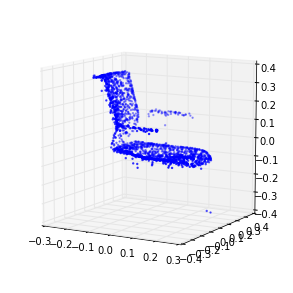

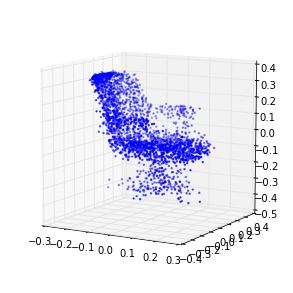

chair002


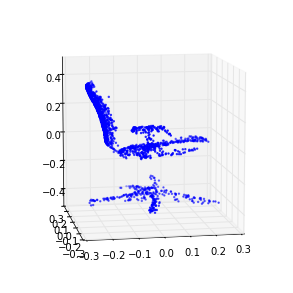

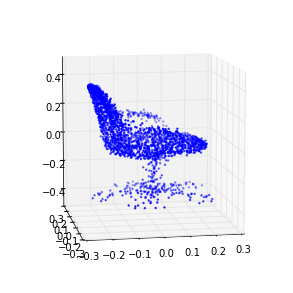

chair003


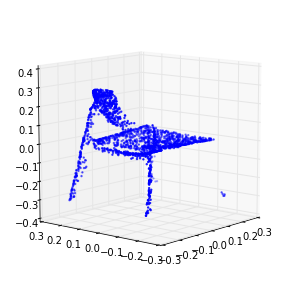

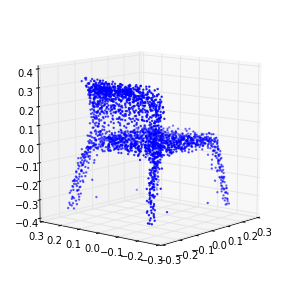

chair006


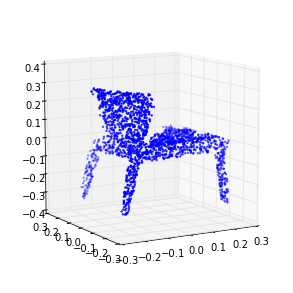

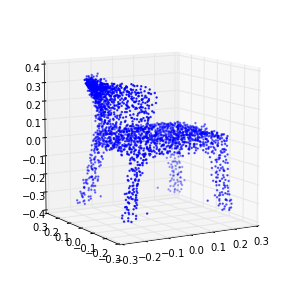

table002


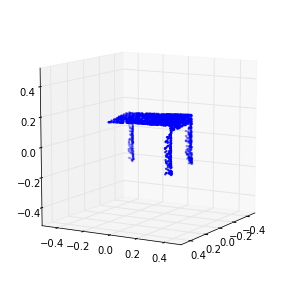

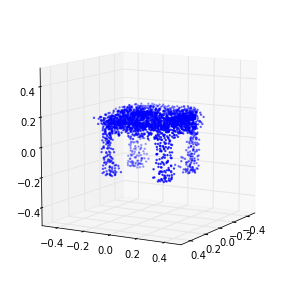

table004


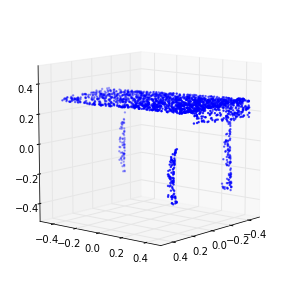

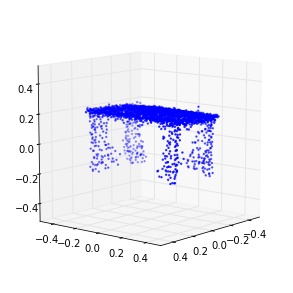

([array([[-0.04787705, -0.23174325,  0.12029848],
         [ 0.14732647,  0.01710199, -0.06427448],
         [ 0.12110861, -0.18009564, -0.05024051],
         ..., 
         [ 0.04376548,  0.1599143 , -0.05104049],
         [-0.10420762, -0.01164063, -0.03308748],
         [-0.14193595,  0.08656021,  0.23382852]]),
  array([[ 0.2152367 , -0.10038195, -0.38940656],
         [ 0.02136295, -0.22135812, -0.00826455],
         [-0.03121512,  0.18681341, -0.37650096],
         ..., 
         [-0.15057842, -0.00877462, -0.37009666],
         [-0.17327806,  0.05370448,  0.01441645],
         [ 0.04233701, -0.08475409,  0.00885045]]),
  array([[-0.18872271,  0.0755154 , -0.02257354],
         [-0.19333221, -0.14709298, -0.00595654],
         [-0.15580234,  0.01081524,  0.09828746],
         ..., 
         [ 0.12727221,  0.00329847,  0.00934645],
         [ 0.11252142,  0.1244342 ,  0.02344047],
         [-0.10808667,  0.19331514,  0.21790444]]),
  array([[-0.24360911, -0.04573882,  0.29222084],

In [12]:
pred_out_dir = create_dir(osp.join(top_data_dir, 'OUT/iccv/real_world_data_predictions/sung_data', predictor_loss, predictor_type + '_ae'))
KinectData.make_predictions(predictor, save_top_dir=pred_out_dir)

In [7]:
# Question: Lin are the rotation angles and the (no) scaling optimal for our generated results?

class KinectData(object):
    '''Real Scan (Kinect) Data used by Sung.
    '''

    top_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Point_Clouds/Partial_PCs/Minhyuk_SigAsia_15/kinect_scan_data/'
    model_names = ['chair001', 'chair002', 'chair003', 'chair006', 'table002', 'table004']

    # Pre-processing for NN (i.e., rotate and swap axis)
    rotation_angles = np.array([-95, -145, 140, 39, 40, 60])
    perm = np.array([[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [1, 0, 2], [1, 0, 2]])

    # Info for Visualization
    azimuth_angles = np.array([300, 260, 220, 240, 30, 40])
    in_u_s = [False, False, False, False, True, True]

    @classmethod
    def make_predictions(cls, nn_model, save_top_dir=None, draft_plot=True):
        incomplete_pclouds = []
        complete_pclouds = []
        incomplete_n_samples = nn_model.n_input[0]
        
        for i, name in enumerate(cls.model_names):            
            print name
                    
            file_name = osp.join(cls.top_dir, name + '_input.ply')
            pc, _ = Point_Cloud(ply_file=file_name).sample(incomplete_n_samples)
            pc.permute_points(cls.perm[i])
            pc.rotate_z_axis_by_degrees(cls.rotation_angles[i])
            pc.center_axis()
            incomplete_pclouds.append(pc.points)
            if save_top_dir is not None:
                pc.save_as_ply(osp.join(save_top_dir, 'incomplete_' + name) )
            
            recon = nn_model.reconstruct(pc.points.reshape(1, incomplete_n_samples, 3), compute_loss=False)[0]            
            recon = Point_Cloud(points=np.squeeze(recon))
            complete_pclouds.append(recon.points)
            if save_top_dir is not None:
                recon.save_as_ply(osp.join(save_top_dir, 'predicted_' + name) )
            
            if draft_plot:
                pc.plot(azim=cls.azimuth_angles[i], s=8, in_u_sphere=cls.in_u_s[i])
                recon.plot(azim=cls.azimuth_angles[i], s=8, in_u_sphere=cls.in_u_s[i])
        
        return incomplete_pclouds, complete_pclouds